## A Social Network Intervention for Improving Organ Donation Awareness in the US

### Objective: 

The organ donation in The study aims to track the digital markers of organ donation in the United States on Twitter. In this notebook, we are going to collect data from twitter and identify two-letter US State from where the tweet is being posted.

### Importing Required Packages

In [2]:
# General
import re
import pandas as pd
import numpy as np
import datetime
import sys
import collections
import pickle

# Twitter Data Extraction
import argparse
from urllib.parse import urlparse
import urllib
from city_to_state import city_to_state_dict
from two_letter_states import us_state_abbrev
## Uncomment the lines below to install tweepy, us packages
#!{sys.executable} -m pip install tweepy
#!{sys.executable} -m pip install us
import tweepy
import us

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Gensim
import gensim
from gensim.utils import simple_preprocess

# NLTK
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

%matplotlib inline

# Result Formatting
from IPython.core.display import display, HTML

def force_show_all(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None):
        display(HTML(df.to_html()))

### Accessing Twitter API in Python

In [3]:
def tw_oauth(authfile):
    with open(authfile, "r") as f:
        ak = f.readlines()
    f.close()
    auth1 = tweepy.auth.OAuthHandler(ak[0].replace("\n", ""), ak[1].replace("\n", ""))
    auth1.set_access_token(ak[2].replace("\n", ""), ak[3].replace("\n", ""))
    return tweepy.API(auth1)

# OAuth key file
authfile = './auth.k.txt'
api = tw_oauth(authfile)

### Twitter Data Extraction 

In [4]:
search_words = "organ donation OR Transplant OR organ donor"
date_since = "2021-08-11"
date_until = "2021-12-31"
max_tweets = 1500
   
# Collect tweets
tweets = tweepy.Cursor(api.search,
              q = search_words,
              #lang="en",
              since=date_since,
              until=date_until,         
              tweet_mode = "extended").items(max_tweets)

data = [[tweet.author.name, tweet.author.screen_name, tweet.author.location, 
         int(tweet.author.geo_enabled),        
         tweet.place.name if hasattr(tweet.place, 'name') else None,
         tweet.place.place_type if hasattr(tweet.place, 'place_type') else None,
         tweet.place.full_name if hasattr(tweet.place, 'full_name') else None,
         
         tweet.place.country_code if hasattr(tweet.place, 'country_code') else None,
         
         tweet.author.description, 
         int(tweet.author.verified), tweet.author.followers_count,
         tweet.author.friends_count, tweet.author.listed_count, tweet.author.favourites_count, 
         tweet.author.statuses_count, tweet.author.created_at, tweet.created_at, 
         tweet.retweeted_status.full_text if hasattr(tweet, 'retweeted_status') else tweet.full_text,
         tweet.source, 
         tweet.retweet_count, tweet.favorite_count, tweet.lang,        
         tweet.entities['hashtags'][0]['text'] if tweet.entities['hashtags'] else None
         #1 if tweet.entities['urls'] else 0,
         #int(tweet.author.default_profile), int(tweet.author.default_profile_image)       
        ]
          for tweet in tweets]



df = pd.DataFrame(data=data, 
                    columns=['User_Name', 'Screen_Name', 'User_Location', 'User_Geo_Enabled', 
                             'Tweet_Geo_Location', 'Tweet_Geo_LocationType', 'Tweet_Geo_LocationFull', 
                             'Tweet_Geo_CountryCode',
                             'User_Description', 
                             'User_Verified', 'User_Followers_Count', 'User_Friends_Count', 'User_Listed_Count',
                            'User_Favorites_Count', 'User_Status_Count', 'User_Since', 'Tweet_Createdon', 'Tweet_Text', 
                             'Tweet_Source', 'Retweet_Count', 
                            'Tweet_Favorites_Count', 'Tweet_Language', 'Tweet_Hashtags'
                            ])

#df
#df[df['User_Default_Image'].notnull()]
#df[df['User_Default_Image']]

### Cleaning the User Location

US States are identified from tweet/author location (which ever is available). Most of them are free-text. So we are using Regular expression to identify the 2 Letter US State.

In [5]:
# In this dictionary, Key: Capital_City | Value: Country
countries_capital = pd.read_excel(r'./List_of_Countries_Capital.xlsx')
countries_capital = pd.Series(countries_capital['Country'].values,index=countries_capital.Capital_City).to_dict()


# In the us_state_dictionary, Key: State full name | Value: State 2 Letter
us_state_abbrev =  dict((k, v.lower()) for k, v in us_state_abbrev.items()) 

def get_state_abbr(x):
    
    # Checking for 2 letter US State mentioned in User Location at the end after comma (e.g. Jersey, NJ)             
    if bool(set([" ".join(x.split()).strip().lower() for x in x.split(',')]).intersection(set(us_state_abbrev.values()))):
        tokens = set([" ".join(x.split()).strip().lower() for x in x.split(',')]).intersection(set(us_state_abbrev.values()))   
    
    # Checking for 2 letter US State mentioned in User Location anywhere in the middle except common words 
    # such as 'in', 'la', 'me', 'oh', 'or' in lowercase. If it is in upper case, it will be considered as an US State
    elif bool(set(re.sub('\W+',' ', x).lower().split()).intersection(us_state_abbrev.values())):
        x_clean = [j.lower() for j in re.sub('\W+',' ', x).split() if j not in ['in', 'la', 'me', 'oh', 'or']]
        tokens = set(x_clean).intersection(us_state_abbrev.values())  
              
    # Checking if User Location is in any other Country
    elif bool(set(re.sub('\W+',' ', x).lower().split()).intersection(set(countries_capital.values()))):
        tokens = set(re.sub('\W+',' ', x).lower().split()).intersection(set(countries_capital.values()))

    # Checking if User Location is a US State in Full form (e.g. Jersey City, New Jersey)                  
    elif bool(set([" ".join(x.split()).strip().lower() for x in x.split(',')]).intersection(set(us_state_abbrev.keys()))):
        tokens = set([" ".join(x.split()).strip().lower() for x in x.split(',')] ).intersection(set(us_state_abbrev.keys()))              
        
    # Checking if User Location is in any other Country Capital State    
    elif bool(set(re.sub('\W+',' ', x).lower().split()).intersection(set(countries_capital.keys()))):
        tokens = set(re.sub('\W+',' ', x).lower().split()).intersection(set(countries_capital.keys()))  

    # Checking if User Location is a US State in Full form (only captures single word state e.g. Ohio) 
    elif bool(set(re.sub('\W+',' ', x).lower().split()).intersection(us_state_abbrev.keys())):
        tokens = set(re.sub('\W+',' ', x).lower().split()).intersection(us_state_abbrev.keys())
      
    else:
        tokens = [j for j in re.split("\s|,", x) if j not in ['in', 'la', 'me', 'oh', 'or']]
    for i in tokens:
        if re.match('\w+', str(i)):
            if us.states.lookup(str(i)):
                return us.states.lookup(str(i)).abbr

            
            
def Get_US_States(row):
    if get_state_abbr(str(row['User_Location'])) == "-":
        value = None
    elif row['Tweet_Geo_LocationFull']:
        value = get_state_abbr(str(row['Tweet_Geo_LocationFull']).upper())
    elif row['User_Location']:
        value = get_state_abbr(str(row['User_Location']).upper())
    else:
        value = None
    return value            
            
df['US_State'] = df.apply(Get_US_States, axis=1)
df['User_Since_Years'] = pd.to_datetime("today").year - pd.to_datetime(df['User_Since']).dt.year

#### Checking if 2 Letter US State is getting extracted from a Sample User Location 

In [6]:
state_df = pd.DataFrame(['New Jersey, NJ', 'NJ, New Jersey', 'Ohio', 'Canada, Ottawa', 'Birmingham, UK', 
                         "(Un)settled in uk", "westerville, oh"], columns=['User_Location'])
state_df['US_State'] = state_df.apply(lambda row : get_state_abbr(row['User_Location']), axis = 1)
state_df

,User_Location,US_State
0,"New Jersey, NJ",NJ
1,"NJ, New Jersey",NJ
2,Ohio,OH
3,"Canada, Ottawa",None
4,"Birmingham, UK",None
5,(Un)settled in uk,None
6,"westerville, oh",OH


#### Let us take a look at the user provided location in twitter and how it matched the two-letter US State. 

In [7]:
df.to_excel(r'./Twitter_Output_Temp.xlsx')
df_USA = df[(df['US_State'].notnull()) & ((df['Tweet_Geo_CountryCode'] == 'US') | (df['Tweet_Geo_CountryCode'].isnull()))]
force_show_all(df_USA[['Tweet_Geo_LocationFull', 'User_Location', 'US_State', 'Tweet_Language']][200:220])

,Tweet_Geo_LocationFull,User_Location,US_State,Tweet_Language
835,None,"Virginia Beach, VA",VA,en
837,None,Arizona,AZ,en
844,None,"Iowa, USA",IA,en
851,None,"Lansing, MI",MI,en
861,None,"Birmingham, England. Prefer Pa",PA,en
863,None,"Sedgefield, Co. Durham",CO,en
885,None,how d,HI,en
887,None,"In BTS' heart ♡ , she / her",IN,en
889,None,in your imagination,IN,en
893,None,BTS ke dil me😭💜,ME,en


### Saving the twitter output every iteration

Since the standard API allows to retrieve tweets up to 7 days ago, we are continuously saving them in the 'Combined_result' dataframe. The duplicate tweets are identified and removed.

In [8]:
# Exclude non-english from the data
df_USA = df_USA[df_USA['Tweet_Language'] == 'en']

## Let us import the 'Twitter_Output.xlsx' file with all tweets that we saved so far
df_original = pd.read_excel(r'./Twitter_Output.xlsx')

## Adding newer tweets to the 'Twitter_Output.xlsx'
Combined_result = pd.concat([df_USA, df_original])
Combined_result = Combined_result[~Combined_result.duplicated(['User_Name', 'Tweet_Createdon', 'Tweet_Text'])]
Combined_result = Combined_result.reset_index(drop=True)
Combined_result.to_excel(r'./Twitter_Output.xlsx', index = False)

### Predicting Twitter Account Type (Individual / Organization)

Now we can use a pre-trained Twitter Account Type Classification model using TFIDF + Logistic Regression Classifier. We are going to create a new column 'Individual'. 0 value indicates that the tweet is from an Organization.

**Assumption:** If the tweet description (bio) is empty, then it is assumed to be an individual

In [9]:
import joblib

vectorizer = "vectorizer.pkl"
model = "Twitter_accounttype_classification_model.pkl"  

loaded_vectorizer = joblib.load(vectorizer)
loaded_model = joblib.load(model)

Combined_result['User_Description'] = Combined_result['User_Description'].fillna('Individual')
X_test = Combined_result['User_Description']
X_test_tfidf = loaded_vectorizer.transform(X_test)
y_predicted = loaded_model.predict(X_test_tfidf)
Combined_result['Individual'] = y_predicted
Combined_result.to_excel(r'./Twitter_Output.xlsx', index = False)

#### Model Predicted Output
Let us take a look at the description and how well the classifier has predicted the Twitter Account Type

In [10]:
force_show_all(Combined_result[['User_Description', 'Individual']][0:20])

,User_Description,Individual
0,"Traditional American, Retired, Love animals. 🇺🇸 Support P. Trump 🇺🇸 Hobbies: Genealogy, History and Researching. Favorite TV Show: The Curse of Oak Island",1
1,Oklahoma🏎,1
2,Racing on in Bryan Clauson’s honor. Competitor in the 103rd running of the Indianapolis 500. #ParkedIt \n\nCMR Apparel: https://t.co/8xLgf9qwBJ,0
3,"Dad, husband, son, friend, and regular guy. Opinions are mine alone.",1
4,radfem,1
5,,1
6,BUBBA ARMY #Istandwithsmoke,1
7,Chicana. Texan. New Yorker. Lawyer. Views are my own.,1
8,Anchor/Reporter | Emmy award winner | 2x Edward R. Murrow recipient | SKYWARN Storm Spotter | Osteochondral Allograft Transplant #DonateLife | UNOS Ambassador,1
9,Anchor/Reporter | Emmy award winner | 2x Edward R. Murrow recipient | SKYWARN Storm Spotter | Osteochondral Allograft Transplant #DonateLife | UNOS Ambassador,1


### Data Pre-Processing

#### Let us take a look at the data

In [11]:
force_show_all(Combined_result[['Screen_Name', 'Individual', 'Tweet_Createdon', 'Tweet_Text', 'US_State']][0:5])

,Screen_Name,Individual,Tweet_Createdon,Tweet_Text,US_State
0,jancappy,1,2021-09-01 21:33:23,"@Rick_Crainium @PhilHarmonic___ @mrshhjones @peljswife @mynameisnotkim1 When I made my will in 2014 through online NOLO . com\nIt also provided the ‘Living Will’ which is your health wishes, organ donor, etc…You want your benefactor know you have this and/or provide to your doctor and hospital especially if you are going to have a major surgery etc.",TX
1,ColeHocker,1,2021-09-01 21:29:30,Bryan Clauson was a LEGEND on and off the track. He saved lives as an organ and tissue donor and started a movement. \n\nJoin the thousands of race fans who have signed up to be an organ donor just like Bryan. Be like Bryan. Be a Legend. \n\nSign up today at https://t.co/4oiIiVWA2a. https://t.co/weP2eV1AxB,OK
2,ClausonMarshall,0,2021-09-01 21:28:50,Bryan Clauson was a LEGEND on and off the track. He saved lives as an organ and tissue donor and started a movement. \n\nJoin the thousands of race fans who have signed up to be an organ donor just like Bryan. Be like Bryan. Be a Legend. \n\nSign up today at https://t.co/4oiIiVWA2a. https://t.co/weP2eV1AxB,IN
3,mattcorvin1,1,2021-09-01 21:00:00,"@SoCalCMH @DavidYoder13 @xan_desanctis There are many people on organ donor waiting lists. SMH.\n\nBut again, congrats, you just made my point. Nobody has a duty to allow another person use of their body.",NY
4,smolgardenghost,1,2021-09-01 20:29:34,"@WheelerThree @benshapiro Let's assume yes. Does that make it acceptable to take organs from the brain dead body? Further, does it make it acceptable to take organs from someone who signed up to be an organ donor who is still conscious?",WA


#### Convert Tweets to String

In [12]:
Combined_result['Tweet_Text'] = Combined_result['Tweet_Text'].apply(str)

#### Count total number of characters and mean length of a tweet

In [13]:
count = Combined_result['Tweet_Text'].str.split().str.len()
count.index = count.index.astype(str) + ' words:'
count.sort_index(inplace=True)

In [14]:
print("Total number of words:", count.sum(), "words")

Total number of words: 87096 words


In [15]:
print("Mean number of words per tweet:", round(count.mean(),2), "words")

Mean number of words per tweet: 34.18 words


In [16]:
Combined_result["Tweet_Length"] = Combined_result["Tweet_Text"].str.len()
print("Total length of the dataset is:", Combined_result.Tweet_Length.sum(), "characters")

Total length of the dataset is: 488741 characters


In [17]:
print("Mean Length of a tweet is:", round(Combined_result.Tweet_Length.mean(),0), "characters")
Combined_result = Combined_result.drop(['Tweet_Length'], axis=1)

Mean Length of a tweet is: 192.0 characters


#### Removing Twitter Handles (@user)

In [18]:
def remove_users(tweet, pattern1, pattern2):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    
    r = re.findall(pattern2, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

Combined_result['tidy_tweet'] = np.vectorize(remove_users)(Combined_result['Tweet_Text'], "@ [\w]*", "@[\w]*")
force_show_all(Combined_result[['Tweet_Text', 'tidy_tweet']][0:2])

,Tweet_Text,tidy_tweet
0,"@Rick_Crainium @PhilHarmonic___ @mrshhjones @peljswife @mynameisnotkim1 When I made my will in 2014 through online NOLO . com\nIt also provided the ‘Living Will’ which is your health wishes, organ donor, etc…You want your benefactor know you have this and/or provide to your doctor and hospital especially if you are going to have a major surgery etc.","When I made my will in 2014 through online NOLO . com\nIt also provided the ‘Living Will’ which is your health wishes, organ donor, etc…You want your benefactor know you have this and/or provide to your doctor and hospital especially if you are going to have a major surgery etc."
1,Bryan Clauson was a LEGEND on and off the track. He saved lives as an organ and tissue donor and started a movement. \n\nJoin the thousands of race fans who have signed up to be an organ donor just like Bryan. Be like Bryan. Be a Legend. \n\nSign up today at https://t.co/4oiIiVWA2a. https://t.co/weP2eV1AxB,Bryan Clauson was a LEGEND on and off the track. He saved lives as an organ and tissue donor and started a movement. \n\nJoin the thousands of race fans who have signed up to be an organ donor just like Bryan. Be like Bryan. Be a Legend. \n\nSign up today at https://t.co/4oiIiVWA2a. https://t.co/weP2eV1AxB


#### Normalization

In [19]:
Combined_result['tidy_tweet'] = Combined_result['tidy_tweet'].str.lower()
force_show_all(Combined_result[['Tweet_Text', 'tidy_tweet', 'Tweet_Hashtags']][0:3])

,Tweet_Text,tidy_tweet,Tweet_Hashtags
0,"@Rick_Crainium @PhilHarmonic___ @mrshhjones @peljswife @mynameisnotkim1 When I made my will in 2014 through online NOLO . com\nIt also provided the ‘Living Will’ which is your health wishes, organ donor, etc…You want your benefactor know you have this and/or provide to your doctor and hospital especially if you are going to have a major surgery etc.","when i made my will in 2014 through online nolo . com\nit also provided the ‘living will’ which is your health wishes, organ donor, etc…you want your benefactor know you have this and/or provide to your doctor and hospital especially if you are going to have a major surgery etc.",None
1,Bryan Clauson was a LEGEND on and off the track. He saved lives as an organ and tissue donor and started a movement. \n\nJoin the thousands of race fans who have signed up to be an organ donor just like Bryan. Be like Bryan. Be a Legend. \n\nSign up today at https://t.co/4oiIiVWA2a. https://t.co/weP2eV1AxB,bryan clauson was a legend on and off the track. he saved lives as an organ and tissue donor and started a movement. \n\njoin the thousands of race fans who have signed up to be an organ donor just like bryan. be like bryan. be a legend. \n\nsign up today at https://t.co/4oiiivwa2a. https://t.co/wep2ev1axb,None
2,Bryan Clauson was a LEGEND on and off the track. He saved lives as an organ and tissue donor and started a movement. \n\nJoin the thousands of race fans who have signed up to be an organ donor just like Bryan. Be like Bryan. Be a Legend. \n\nSign up today at https://t.co/4oiIiVWA2a. https://t.co/weP2eV1AxB,bryan clauson was a legend on and off the track. he saved lives as an organ and tissue donor and started a movement. \n\njoin the thousands of race fans who have signed up to be an organ donor just like bryan. be like bryan. be a legend. \n\nsign up today at https://t.co/4oiiivwa2a. https://t.co/wep2ev1axb,None


#### Hashtag Frequency Table

In [20]:
def extract_hash_tags(s):
    return set(part[1:] for part in s.split() if part.startswith('#'))

Combined_result['tidy_hashtags'] = np.where(Combined_result['Tweet_Hashtags'].isnull(), 
                                            Combined_result.apply(lambda row : 
                                                                  next(iter(extract_hash_tags(row['tidy_tweet'])), None), 
                                                                  axis = 1), 
                                            Combined_result['Tweet_Hashtags'])
#Combined_result['tidy_hashtags'] = Combined_result['tidy_hashtags'].apply(str)
force_show_all(Combined_result[['Tweet_Text', 'tidy_tweet', 'Tweet_Hashtags', 'tidy_hashtags']][5:10])

,Tweet_Text,tidy_tweet,Tweet_Hashtags,tidy_hashtags
5,Bryan Clauson was a LEGEND on and off the track. He saved lives as an organ and tissue donor and started a movement. \n\nJoin the thousands of race fans who have signed up to be an organ donor just like Bryan. Be like Bryan. Be a Legend. \n\nSign up today at https://t.co/4oiIiVWA2a. https://t.co/weP2eV1AxB,bryan clauson was a legend on and off the track. he saved lives as an organ and tissue donor and started a movement. \n\njoin the thousands of race fans who have signed up to be an organ donor just like bryan. be like bryan. be a legend. \n\nsign up today at https://t.co/4oiiivwa2a. https://t.co/wep2ev1axb,None,None
6,Bryan Clauson was a LEGEND on and off the track. He saved lives as an organ and tissue donor and started a movement. \n\nJoin the thousands of race fans who have signed up to be an organ donor just like Bryan. Be like Bryan. Be a Legend. \n\nSign up today at https://t.co/4oiIiVWA2a. https://t.co/weP2eV1AxB,bryan clauson was a legend on and off the track. he saved lives as an organ and tissue donor and started a movement. \n\njoin the thousands of race fans who have signed up to be an organ donor just like bryan. be like bryan. be a legend. \n\nsign up today at https://t.co/4oiiivwa2a. https://t.co/wep2ev1axb,None,None
7,"@pendeferous @langbdang @palazzo214 @steve_vladeck Thanks being an organ donor! (No sarcasm, we need organ donors.) But that actually brings up a great point—we don’t even take organs from cadavers without express permission, even to save multiple lives.","thanks being an organ donor! (no sarcasm, we need organ donors.) but that actually brings up a great point—we don’t even take organs from cadavers without express permission, even to save multiple lives.",None,None
8,"To register to become an organ/tissue donor, click the link below \n\nhttps://t.co/S6PTPHjk5V","to register to become an organ/tissue donor, click the link below \n\nhttps://t.co/s6ptphjk5v",None,None
9,"I wrote to my girl’s family today. It’s the most important thing I’ve ever written, and the most painful. I have never wanted someone to reach out to me more. I pray they do. But I understand if they don’t. \n\nIf you haven’t registered to become an organ/tissue donor, please do https://t.co/nPSNfGQibm","i wrote to my girl’s family today. it’s the most important thing i’ve ever written, and the most painful. i have never wanted someone to reach out to me more. i pray they do. but i understand if they don’t. \n\nif you haven’t registered to become an organ/tissue donor, please do https://t.co/npsnfgqibm",None,None


In [21]:
d = Combined_result.groupby('tidy_hashtags')['tidy_hashtags'].count()
df_hashtags = pd.DataFrame([d]).T

df_hashtags.columns = ['freq']
df_hashtags.freq.sum()

405

In [22]:
df_hashtags.sort_values(by=['freq'], ascending=False, inplace=True)
force_show_all(df_hashtags[0:10])

,freq
tidy_hashtags,
DonateLife,34
donatelife,19
YOUNGJAE,16
HighFive,15
hospitalplaylist2,15
NMDAM,15
organ,14
LeaveThemCertain,14
DYK,11


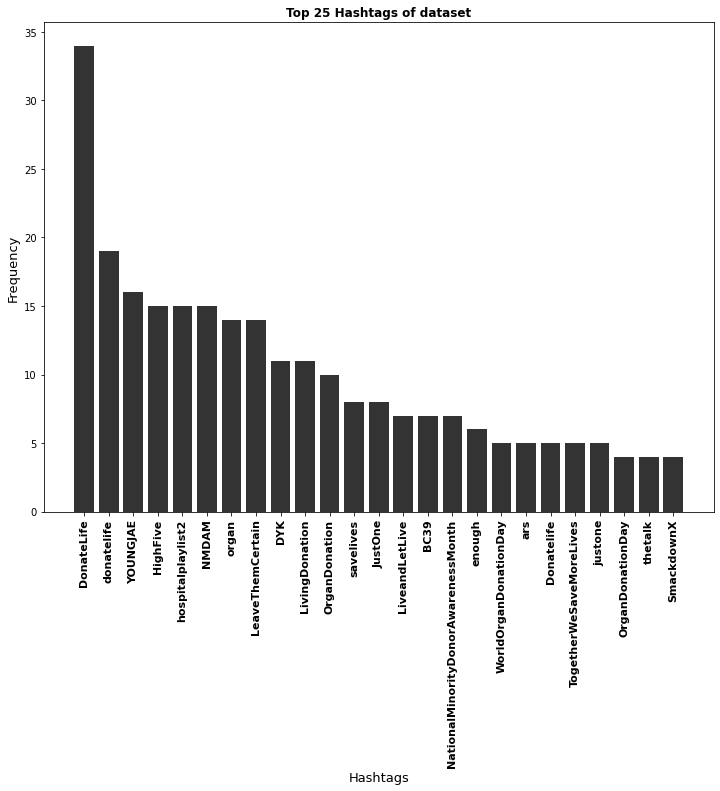

In [23]:
# Visualization of Top 25 Hashtags
labels = df_hashtags.head(25).index.values.tolist()
freq = df_hashtags['freq'].head(25).values.tolist()
index = np.arange(len(freq))

plt.figure(figsize=(12,9))
plt.bar(index, freq, alpha=0.8, color= 'black')
plt.xlabel('Hashtags', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.xticks(index, labels, fontsize=11, rotation=90, fontweight="bold") 
plt.title('Top 25 Hashtags of dataset', fontsize=12, fontweight="bold")
plt.show()

#### Remove Hashtags from tweets

In [24]:
def remove_hashtags(tweet, pattern1, pattern2):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    
    r = re.findall(pattern2, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

Combined_result['tidy_tweet'] = np.vectorize(remove_hashtags)(Combined_result['tidy_tweet'], "# [\w]*", "#[\w]*")
force_show_all(Combined_result[['Tweet_Text', 'tidy_tweet']][4:5])

,Tweet_Text,tidy_tweet
4,"@WheelerThree @benshapiro Let's assume yes. Does that make it acceptable to take organs from the brain dead body? Further, does it make it acceptable to take organs from someone who signed up to be an organ donor who is still conscious?","let's assume yes. does that make it acceptable to take organs from the brain dead body? further, does it make it acceptable to take organs from someone who signed up to be an organ donor who is still conscious?"


#### Remove Links

In [25]:
def remove_links(tweet):
    tweet_no_link = re.sub(r"http\S+", "", tweet)
    return tweet_no_link

Combined_result['tidy_tweet'] = np.vectorize(remove_links)(Combined_result['tidy_tweet'])
force_show_all(Combined_result[['Tweet_Text', 'tidy_tweet']][4:5])

,Tweet_Text,tidy_tweet
4,"@WheelerThree @benshapiro Let's assume yes. Does that make it acceptable to take organs from the brain dead body? Further, does it make it acceptable to take organs from someone who signed up to be an organ donor who is still conscious?","let's assume yes. does that make it acceptable to take organs from the brain dead body? further, does it make it acceptable to take organs from someone who signed up to be an organ donor who is still conscious?"


#### Removing Punctuations, Numbers, and Special Characters

In [26]:
Combined_result['tidy_tweet'] = Combined_result['tidy_tweet'].str.replace("[^a-zA-Z#]", " ", regex = True)
force_show_all(Combined_result[['Tweet_Text', 'tidy_tweet']][4:5])

,Tweet_Text,tidy_tweet
4,"@WheelerThree @benshapiro Let's assume yes. Does that make it acceptable to take organs from the brain dead body? Further, does it make it acceptable to take organs from someone who signed up to be an organ donor who is still conscious?",let s assume yes does that make it acceptable to take organs from the brain dead body further does it make it acceptable to take organs from someone who signed up to be an organ donor who is still conscious


#### Remove short words

In [27]:
Combined_result['tidy_tweet'] = Combined_result['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
force_show_all(Combined_result[['Tweet_Text', 'tidy_tweet']][4:5])

,Tweet_Text,tidy_tweet
4,"@WheelerThree @benshapiro Let's assume yes. Does that make it acceptable to take organs from the brain dead body? Further, does it make it acceptable to take organs from someone who signed up to be an organ donor who is still conscious?",assume does that make acceptable take organs from brain dead body further does make acceptable take organs from someone signed organ donor still conscious


#### Tokenize words and clean-up Punctuations

In [28]:
def tokenize(tweet):
    for word in tweet:
        yield(gensim.utils.simple_preprocess(str(word), deacc=True))
        
Combined_result['tidy_tweet_tokens'] = list(tokenize(Combined_result['tidy_tweet']))      
force_show_all(Combined_result[['Tweet_Text', 'tidy_tweet', 'tidy_tweet_tokens']][4:5])

,Tweet_Text,tidy_tweet,tidy_tweet_tokens
4,"@WheelerThree @benshapiro Let's assume yes. Does that make it acceptable to take organs from the brain dead body? Further, does it make it acceptable to take organs from someone who signed up to be an organ donor who is still conscious?",assume does that make acceptable take organs from brain dead body further does make acceptable take organs from someone signed organ donor still conscious,"[assume, does, that, make, acceptable, take, organs, from, brain, dead, body, further, does, make, acceptable, take, organs, from, someone, signed, organ, donor, still, conscious]"


#### Remove Stopwords

In [29]:
# Prepare Stop Words
stop_words = stopwords.words('english')
stop_words.extend(['from', 'https', 'twitter','twitt',])


def remove_stopwords(tweets):
    return [[word for word in simple_preprocess(str(tweet)) if word not in stop_words] for tweet in tweets]


Combined_result['tokens_no_stop'] = remove_stopwords(Combined_result['tidy_tweet_tokens'])
force_show_all(Combined_result[['Tweet_Text', 'tidy_tweet', 'tidy_tweet_tokens', 'tokens_no_stop']][69:70])

,Tweet_Text,tidy_tweet,tidy_tweet_tokens,tokens_no_stop
69,"As an organ donor, I hope they donate my tattoos as well",organ donor hope they donate tattoos well,"[organ, donor, hope, they, donate, tattoos, well]","[organ, donor, hope, donate, tattoos, well]"


#### WordCloud

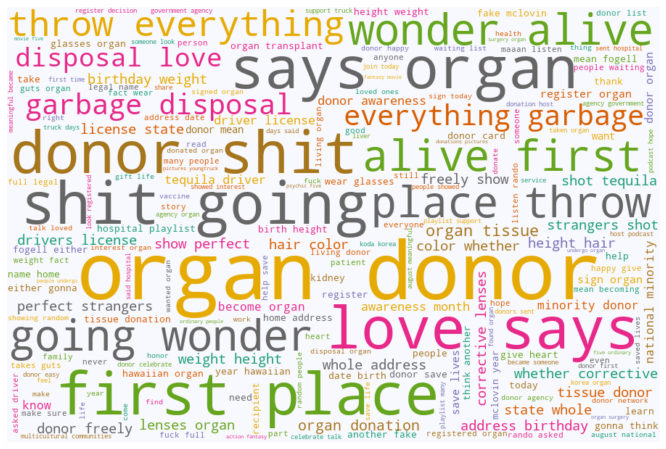

In [30]:
# Join the tweet back together
def rejoin_words(row):
    words = row['tokens_no_stop']
    joined_words = (" ".join(words))
    return joined_words

Combined_result['no_stop_joined'] = Combined_result.apply(rejoin_words, axis=1)
all_words = ' '.join([text for text in Combined_result['no_stop_joined']])

wordcloud = WordCloud(width=900, height=600, random_state=21, max_font_size=110, background_color='ghostwhite', 
                      max_words=200,colormap='Dark2').generate(all_words)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


#### Number of words/tweet with a cleaned tweet dataset

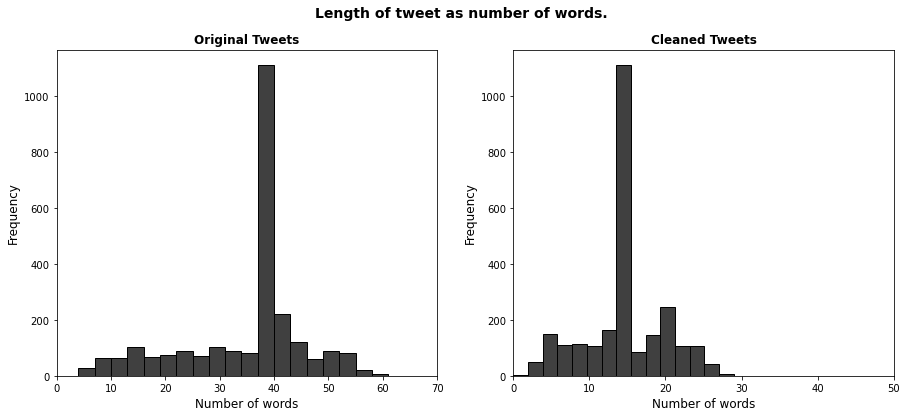

In [31]:
Combined_result["tweet_words"] = Combined_result['Tweet_Text'].str.split().str.len()
Combined_result["cleaned_tweet_words"] = Combined_result["no_stop_joined"].str.split().str.len()
df_lengths = Combined_result[['tweet_words', 'cleaned_tweet_words']]

x_1 = df_lengths.tweet_words
x_2 = df_lengths.cleaned_tweet_words
plt.figure(figsize=(15,6))
plt.suptitle('Length of tweet as number of words.', fontsize=14, fontweight="bold")
plt.subplot(1,2,1)
sns.histplot(x_1, color="black", label="No. Words", bins=25)
plt.title("Original Tweets",fontsize=12, fontweight="bold")
plt.xlabel("Number of words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlim([0,70])



# Chart 2: Derivative Function
plt.subplot(1,2,2)
sns.histplot(x_2, color="black", label="No. Words", bins=15)
plt.title("Cleaned Tweets",fontsize=12, fontweight="bold")
plt.xlabel("Number of words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlim([0,50])

plt.show()

In [32]:
Combined_result = Combined_result.drop(['tweet_words', 'cleaned_tweet_words'], axis=1)

#### Top 25 - Most Frequently Used Words

Unique words: 2924


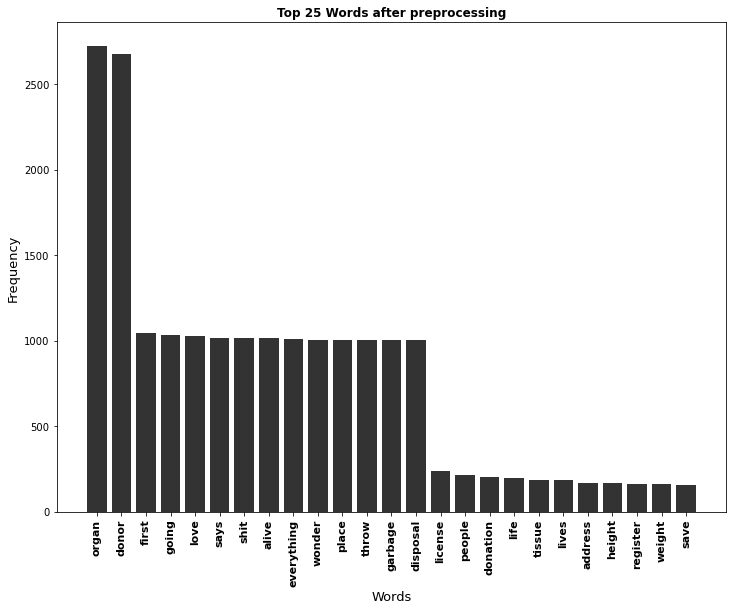

In [33]:
word_freq = pd.Series(np.concatenate([x.split() for x in Combined_result.no_stop_joined])).value_counts()
word_df = pd.Series.to_frame(word_freq)
word_df['word'] = list(word_df.index)
word_df.reset_index(drop=True, inplace=True)
word_df.columns = ['freq', 'word']
label = word_df['word'].head(25)
freq = word_df['freq'].head(25)
index = np.arange(len(freq))

print("Unique words:", len(word_df))
plt.figure(figsize=(12,9))
plt.bar(index, freq, alpha=0.8, color= 'black')
plt.xlabel('Words', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.xticks(index, label, fontsize=11, rotation=90, fontweight="bold") 
plt.title('Top 25 Words after preprocessing', fontsize=12, fontweight="bold")
plt.show()

#### Save Dataframe

In [34]:
Combined_result.to_pickle('pre-processed.pkl')

### END - Continues to Topic Modeling